# First, import the needed libraries and files

You only need the bond list and the coordinates of the nodes in a network to be able to use rigidpy. I have added a sample network here. The bond list contains information about nodes that are connected. For example (0,1) means nodes 0 and 1 are connected. The coordinates is an array of x and y coordinates for all the nodes. The number of row in the array shows the label of node in the network.

In [1]:
import networkx as nx
import numpy as np
import rigidpy as rp
import matplotlib.pyplot as plt
%matplotlib inline

bonds = np.loadtxt("./bonds.dat", dtype = int)
coordinates = np.loadtxt("./coordinates.dat",dtype=float)

# Plot the network

This is a piece of code that plots the network in 2D. The sample network here has periodic boundaries and is wrapped arround a torus, meaning that the upper edge is connetced to the lower edge and the left and right hand sides are also connected. If you want to see the network with its long bonds that connect the edges, set the cutoff variable to 1 which is the box size. If you want to only see the short bonds, set the cutoff to a smaller number like cutoff = 0.5. 

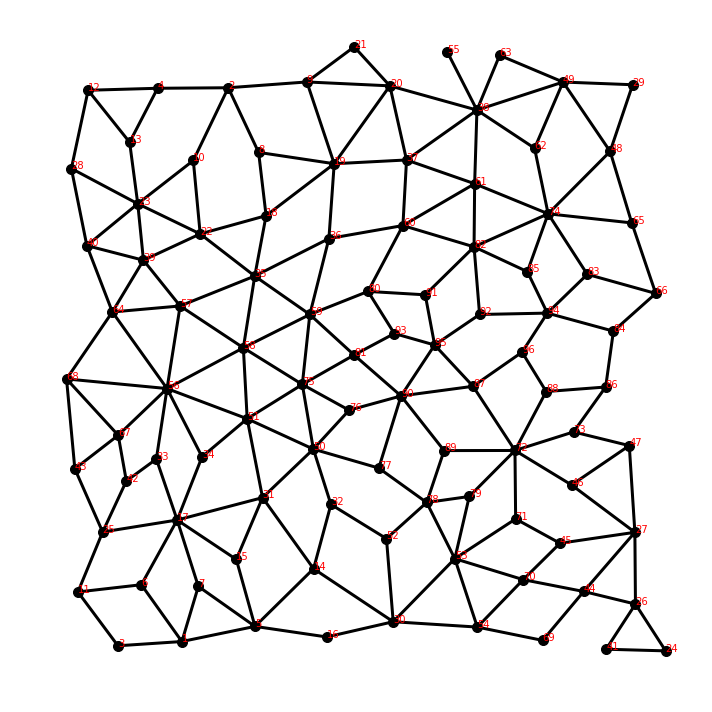

In [2]:
cutoff = 0.5 # This is a cutoff so we don't plot the long bonds that represent periodic boundary
N = len(coordinates)
M = len(bonds)

# Find the short bonds
d = coordinates[bonds]
lengths = np.linalg.norm(d[:,0]-d[:,1],axis=-1)
short_idx = lengths < cutoff
sb = bonds[short_idx]
# sites are the nodes that appear in the bond list. 
# If a node is not connected to anything, it won't be plotted.
sites = np.unique(bonds.flatten()) 

# Now the plotting begins
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.set_axis_off()
# First plot the bonds
def bond_plot(coordinates,bondlist):
    x,y = [], []
    for item in bondlist:
        xs = coordinates[item][:,0]
        ys = coordinates[item][:,1]
        x.extend(xs)
        x.append(None)
        y.extend(ys)
        y.append(None)
    return x,y

x, y = bond_plot(coordinates,sb)
ax.plot(x, y, color = 'k', lw = 3,zorder=1)

# Then plot the nodes
ax.scatter(coordinates[sites,0],coordinates[sites,1], color = 'k', s = 100,zorder=2)

# Writing the numbers of sites on them
for i in range(1,N+1):
    ax.text(coordinates[i-1,0],coordinates[i-1,1],i, fontsize = 10, color = 'r',zorder=3)

plt.tight_layout()
#plt.savefig('./networkPicture.pdf',dpi=300,transparent=True)

# Build a framework using rigidpy and then use it to study the rigidity and vibrational modes of the network

In [17]:
# The lattic vectors represent the box shape
a1 = np.array([1.0, 0.0]) # lattice vector 1
a2 = np.array([0.0, 1.0]) # lattice vector 2
basis = np.array([a1,a2])
# You can assign stiffnesses to the springs. Here they're all 1.
stiffness = np.ones(len(bonds)) 
# You can assign rest lengths to the springs:
L0 = np.ones(len(bonds))*0.1
# Now build a framework obejct:
# Framework is used to study the structural properties of the network
F = rp.Framework(coordinates, bonds, basis, k=stiffness, restlengths=L0)
# The Configuration object is used for energy minimization
CON = rp.Configuration(coordinates, bonds, basis, k=stiffness) 

# A few measurements

Now that the Framework is built, you can compute many of the properties of the network. 
Note that when the system is not under compression or tension, the Hessian matrix is the same as dynamical matrix which is given by $R^T R$ where R is the rigidity matrix. But when the system is under compression or tension (and therefore there is prestress in the system), the Hessian can be broken into two pieces: one piece is the stabilizing term which is again just the dynamical matrix and the other one is a destabilizing term which includes the pre-stress forces on the bonds due to external compression or tension on the network. Note that if you set $restlengths = None$ when building a Framework, the destabilizing term will be zero.

In [12]:
edgeLengths = F.EdgeLengths() # The correct lengtsh of the bonds. You can set this to be your rest lengths.
bulkModulus = F.BulkModulus() # The bulk modulus
shearModulus = F.ShearModulus() # The pure shear modulus
RigidityMatrix = F.RigidityMatrix() # The rigidity matrix
HessianMatrix = F.HessianMatrix() # The full Hessian 

# Now let's deform the system and see how much the energy of the system changes

Note that the energy minimizer has two arguments. One of the them is L which is the lengths to which you want to minimize the energy (lengths after the network has been compressed) and the other one is the restlengths which is the actual rest lengths of the springs. 

In [19]:
def strainMatrix(c1, c2, basis):
    '''
    This function gets the basis vectors of a 2D
    Network, multiplies the first vector by c1 and
    the second vector by c2 and makes a new basis.
    '''
    sm = np.zeros((2,2))
    sm[0,0] = c1
    sm[1,1] = c2
    return np.multiply(sm,basis)

eps = 1e-2 # The strain
c1 = 1.0 - eps 
c2 = 1.0 - eps
newBasis = strainMatrix(c1, c2, basis)
newF = rp.Framework(coordinates, bonds, newBasis, k=stiffness)
newLengths = newF.EdgeLengths()
CON = rp.Configuration(coordinates, bonds, newBasis, k=stiffness) # This is used to study the energy of the system
newCoordinates = CON.energy_minimize_Newton(L = edgeLengths, restlengths = L0) # this minimizes the energy and as a result, the nodes move
E = CON.finalenergy # what's the final energy stored in the system after deformation?
print(E)
finalF = rp.Framework(newCoordinates, bonds, newBasis, k=stiffness)
finalLengths = finalF.EdgeLengths()
0.5*np.sum((restLengths - finalLengths)**2)

0.0001288528794962029


0.0001288528794962029